In [1]:
import backtrader as bt
import pandas as pd
import duckdb

etfs = ['561300', '159726', '515100', '513500', '161119',
        '518880', '164824', '159985', '513330', '513100',
        '513030', '513520']
start_date = '2023-01-18'
end_date   = '2025-08-18'

con = duckdb.connect(database=':memory:', read_only=False) 
symbols_tuple = tuple(etfs)

path = '../dataset/data/etf_prices/**/data.parquet'

query = f"""
SELECT
    date,
    open,
    high,
    low,
    close,
    volume,
    turnover,
    symbol
FROM read_parquet('{path}')
WHERE symbol IN {symbols_tuple}
AND date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY symbol, date
"""

df_all = con.execute(query).df()
con.close()

# 类型转换
df_all['date'] = pd.to_datetime(df_all['date'])
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
df_all[numeric_cols] = df_all[numeric_cols].astype(float)
df_all.tail(10)

,date,open,high,low,close,volume,turnover,symbol
2917,2025-08-05,0.876,0.880,0.871,0.878,299286.0,26168527.0,561300
2918,2025-08-06,0.877,0.883,0.877,0.882,103807.0,9139153.0,561300
2919,2025-08-07,0.882,0.884,0.877,0.882,356188.0,31385226.0,561300
2920,2025-08-08,0.882,0.885,0.879,0.882,135361.0,11931573.0,561300
2921,2025-08-11,0.880,0.887,0.880,0.884,230844.0,20411420.0,561300
2922,2025-08-12,0.883,0.890,0.882,0.888,358191.0,31773432.0,561300
2923,2025-08-13,0.888,0.900,0.888,0.897,266841.0,23871007.0,561300
2924,2025-08-14,0.898,0.906,0.895,0.896,453259.0,40863159.0,561300
2925,2025-08-15,0.895,0.905,0.894,0.902,877880.0,79046221.0,561300
2926,2025-08-18,0.904,0.915,0.902,0.909,594706.0,54086799.0,561300


In [2]:
# ------------------------------------------------------------------
# 2. 构造 cerebro 并循环添加每个 ETF 的数据
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

for symbol in etfs:
    # 取出当前标的
    df_sym = df_all[df_all['symbol'] == symbol].copy()

    # 确保按日期排序
    df_sym.sort_values('date', inplace=True)

    # 设置 datetime 为索引
    df_sym.set_index('date', inplace=True)

    # 删除多余的 symbol 列
    df_sym.drop(columns=['symbol'], inplace=True)

    # 缺失值前向填充（如有停牌）
    df_sym = df_sym.ffill()

    # 构建 backtrader 数据源
    data = bt.feeds.PandasData(
        dataname=df_sym,
        name=symbol,
        # 如果列名与默认一致，无需额外映射
    )
    cerebro.adddata(data)
# ------------------------------------------------------------------
# 3. 示例策略：每天收盘后打印所有标的价格
# ------------------------------------------------------------------
class MomentumTopN(bt.Strategy):
    params = (
        ('momentum_period', 13),   # 动量周期
        ('ma_period', 120),        # 均线周期
        ('topn', 3),               # 每期最大持仓数
        ('rebalance_days', 5),     # 调仓间隔
    )

    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = dict(
                momentum=bt.indicators.ROC(d.close,
                                           period=self.p.momentum_period),
                ma=bt.indicators.SimpleMovingAverage(d.close,
                                                     period=self.p.ma_period)
            )
        self.counter = 0

    def next(self):
        self.counter += 1
        if self.counter % self.p.rebalance_days != 0:
            return  # 不到调仓日
        # 1. 过滤：收盘价必须站在 120 日均线上方
        eligible = []
        for d in self.datas:
            if len(d) >= max(self.p.momentum_period, self.p.ma_period):
                if d.close[0] > self.inds[d]['ma'][0]:
                    eligible.append(d)

        # 2. 按 20 日动量排序（从高到低）
        eligible.sort(key=lambda d: self.inds[d]['momentum'][0], reverse=True)

        # 3. 选出 TopN
        top = eligible[:self.p.topn]

        # 4. 计算等权权重
        weight = 1.0 / len(top) if top else 0.0

        # 5. 调仓：清仓不在 top 的，买入新的
        for d in self.datas:
            pos = self.getposition(d).size
            if d in top:
                target_size = int((weight * self.broker.getvalue()) / d.close[0])
                if pos != target_size:
                    self.order_target_size(d, target_size)
            else:
                if pos:
                    self.order_target_size(d, 0)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

cerebro.addstrategy(MomentumTopN)
cerebro.broker.setcommission(commission=0.0005)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.broker.setcash(100000) 

# ------------------------------------------------------------------
# 4. 运行回测
# ------------------------------------------------------------------
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

                           Strategy
-------------------------  ----------
Start Period               2024-08-15
End Period                 2025-08-18
Risk-Free Rate             0.0%
Time in Market             49.0%

Cumulative Return          1.83%
CAGR﹪                     1.89%

Sharpe                     0.26
Prob. Sharpe Ratio         59.97%
Smart Sharpe               0.25
Sortino                    0.33
Smart Sortino              0.31
Sortino/√2                 0.23
Smart Sortino/√2           0.22
Omega                      1.08

Max Drawdown               -7.11%
Max DD Date                2025-04-07
Max DD Period Start        2025-02-27
Max DD Period End          2025-07-30
Longest DD Days            154
Volatility (ann.)          8.51%
Calmar                     0.27
Skew                       -2.42
Kurtosis                   19.37

Expected Daily %           0.01%
Expected Monthly %         0.14%
Expected Yearly %          0.91%
Kelly Criterion            3.92%
Risk of Ruin    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2025-02-27,2025-04-07,2025-07-30,154,-7.108544,-5.851096
2,2025-08-01,2025-08-04,2025-08-12,12,-1.937382,-1.113808
3,2025-08-18,2025-08-18,2025-08-18,1,-0.449667,NaN
4,2025-08-14,2025-08-14,2025-08-14,1,-0.094330,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


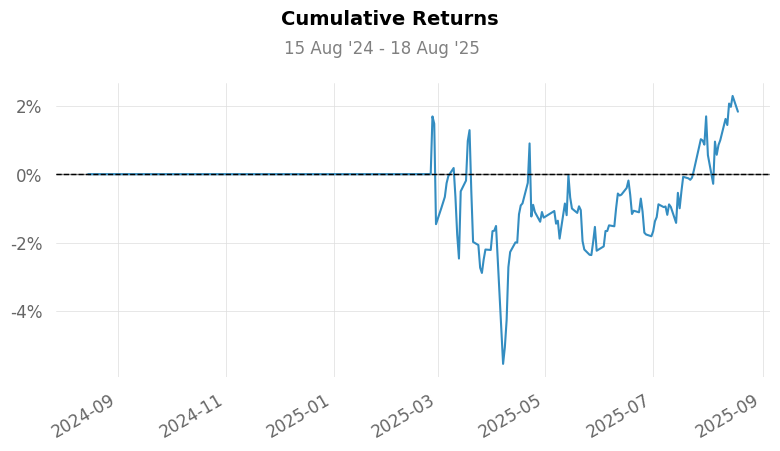

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


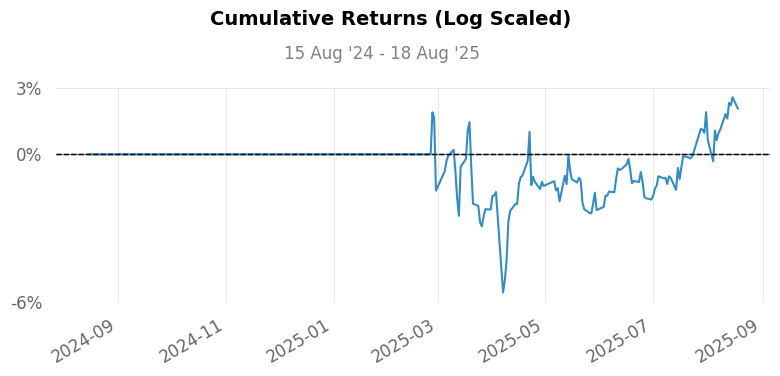

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


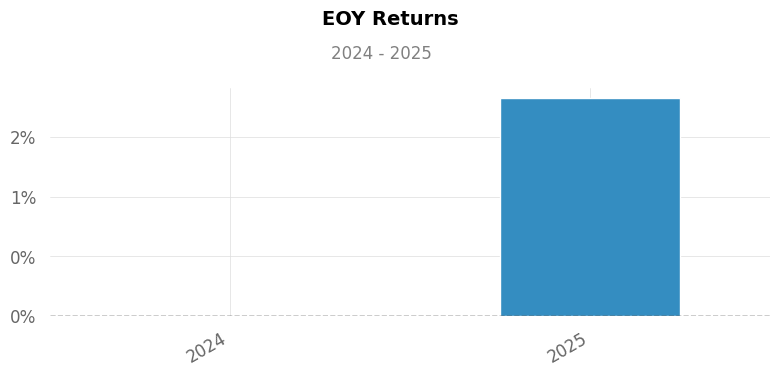

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


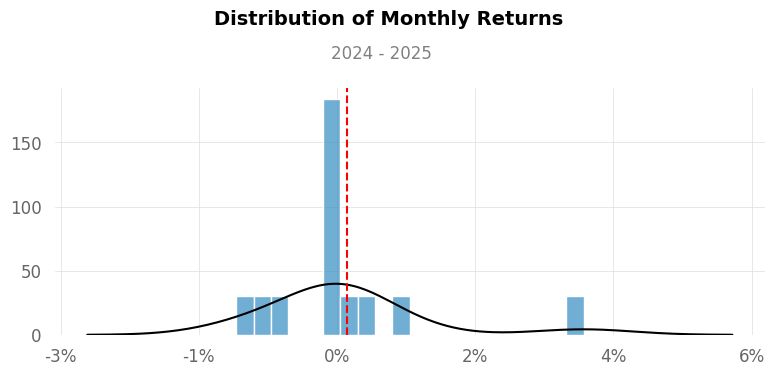

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


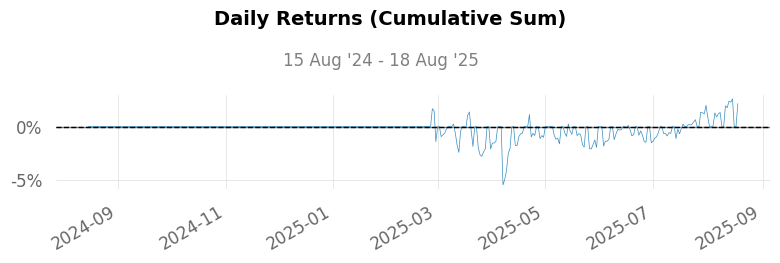

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


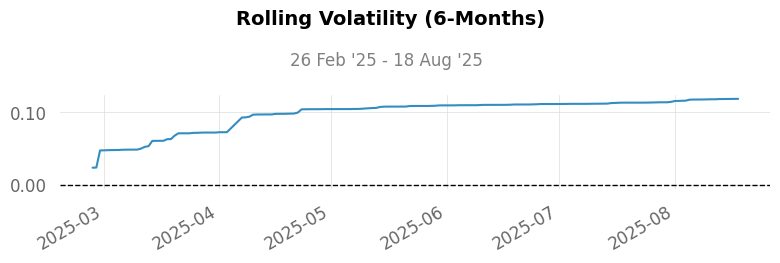

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


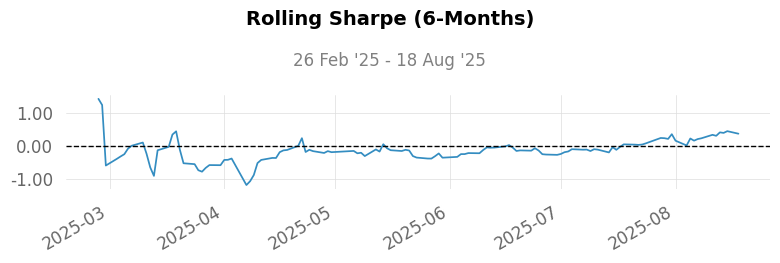

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


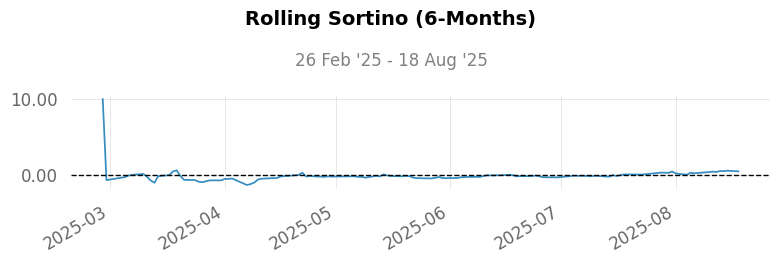

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


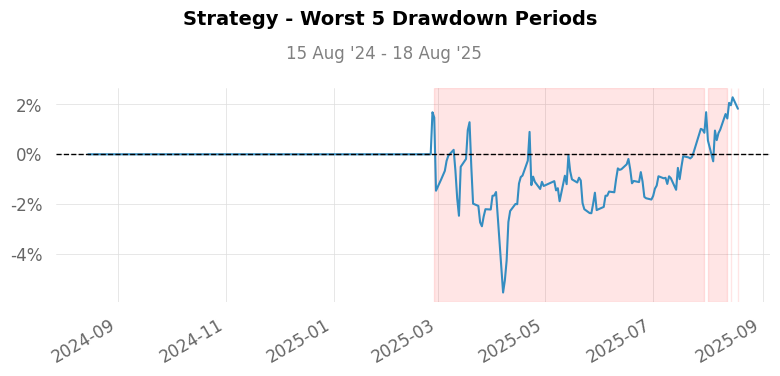

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


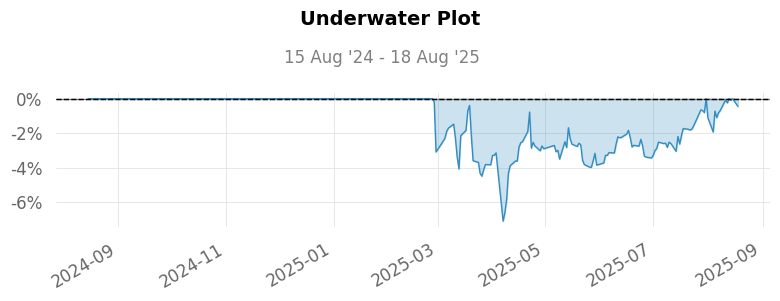

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


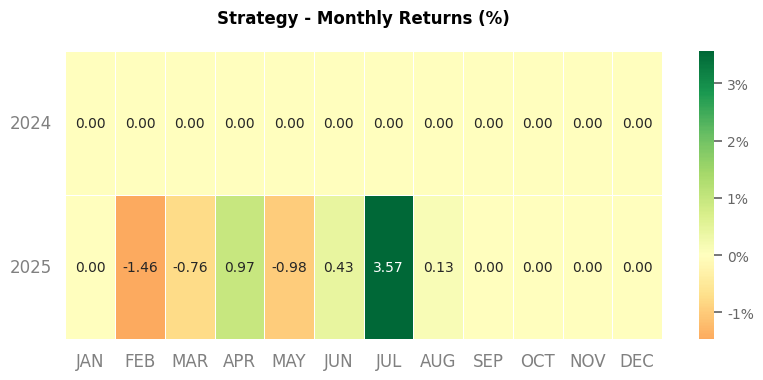

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


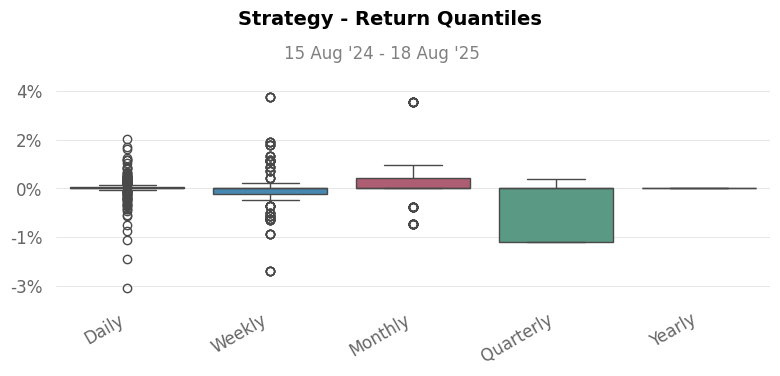

In [3]:
import quantstats as qs

qs.reports.full(returns)

In [15]:
positions

,513520,cash
Datetime,,
2024-08-15 00:00:00+00:00,0.0,100000.000000
2024-08-16 00:00:00+00:00,0.0,100000.000000
2024-08-19 00:00:00+00:00,0.0,100000.000000
2024-08-20 00:00:00+00:00,0.0,100000.000000
2024-08-21 00:00:00+00:00,0.0,100000.000000
...,...,...
2025-08-12 00:00:00+00:00,0.0,33047.933249
2025-08-13 00:00:00+00:00,0.0,33047.933249
2025-08-14 00:00:00+00:00,0.0,33047.933249


In [11]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2022-12-30 00:00:00+00:00,841,3.970,5,518880,-3338.770
2022-12-30 00:00:00+00:00,1678,1.987,7,159985,-3334.186
2023-01-09 00:00:00+00:00,3944,0.842,1,159726,-3320.848
2023-01-09 00:00:00+00:00,-9,4.016,5,518880,36.144
2023-01-09 00:00:00+00:00,-1678,1.955,7,159985,3280.490
...,...,...,...,...,...
2025-07-11 00:00:00+00:00,-1,4.248,3,513500,4.248
2025-07-11 00:00:00+00:00,501,8.170,9,513100,-4093.170
2025-07-18 00:00:00+00:00,-969,4.282,3,513500,4149.258
